Training evaluation measures how well NLP models perform on real business problems. 

## Overview: Evaluation Types
**Intrinsic evaluation:** Tests individual NLP components (subtasks).
- Confusion matrix, F1 score, AUC, RMSE, Perplexity, METEOR, ROUGE

**Extrinsic evaluation:** Measures end-to-end business impact.
- Stakeholders care about this: "Does it solve our problem?"

**Key takeaway:** Use intrinsic metrics during development, extrinsic for production success.

## Example: Twitter Sentiment Demo (Step-by-Step)
Builds binary classifier (positive=1, negative=0) on 10K labeled tweets (5K each class).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Step 1: Load Data
import nltk
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/vinny/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [4]:
from nltk.corpus import twitter_samples
tweets_pos = twitter_samples.strings('positive_tweets.json')     #  5000
tweets_neg = twitter_samples.strings('negative_tweets.json')     #  5000
tweets_all = tweets_pos + tweets_neg                             # 10000

In [6]:
labels_pos = np.ones ((len(tweets_pos),1), dtype=np.int8)  # positive labels (1)
labels_neg = np.zeros((len(tweets_neg),1), dtype=np.int8)  # negative labels (0)
labels_all = np.append(labels_pos,labels_neg)              # all labels

In [7]:
pd.DataFrame(data={'tweet':tweets_all,'label':labels_all})

,tweet,label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...
9995,I wanna change my avi but uSanele :(,0
9996,MY PUPPY BROKE HER FOOT :(,0
9997,where's all the jaebum baby pictures :((,0
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0


In [8]:
# Step 2: Train/Test Split
# - 75% train (7,500 tweets), 25% test (2,500 tweets)
# - `train_test_split()` from scikit-learn

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets_all, labels_all,
                                                    test_size=0.25, 
                                                    random_state=243824)

len(X_train), len(X_test), len(y_train), len(y_test)

(7500, 2500, 7500, 2500)

In [ ]:
# Step 3: Preprocessing Pipeline

# 1) TweetTokenizer
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
X_train_tok = [tokenizer.tokenize(tweet) for tweet in X_train]

In [11]:
n = 47
X_train[n],X_train_tok[n]

("@hawkins_g omg you're so mean, he's fine :(",
 ['omg', "you're", 'so', 'mean', ',', "he's", 'fine', ':('])

In [12]:
# 2) Remove stopwords

from nltk.corpus import stopwords
swords = stopwords.words('english')

X_train_tok_nostop = []
for tweet in X_train_tok:
    words = [word for word in tweet if word not in swords]
    X_train_tok_nostop.append(words)

X_train_tok_nostop[89]

['thx', 'tobi-bro', '!', ':D']

In [13]:
# 3) Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

X_train_tok_nostop_stem = []
for tweet in X_train_tok_nostop:
    words = [stemmer.stem(word) for word in tweet]
    X_train_tok_nostop_stem.append(words)

X_train_tok_nostop_stem[89]

['thx', 'tobi-bro', '!', ':d']

In [14]:
# Put it all into a function
def preprocess_text(tweets):

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    stemmer = PorterStemmer()
    swords = stopwords.words('english')

    X = []
    for tweet in tweets:
        tokens = tokenizer.tokenize(tweet)
        X.append([stemmer.stem(word) for word in tokens if word not in swords]) 
        
    return X

In [15]:
X_train_pp = preprocess_text(X_train)

In [ ]:
keys = ['❤', '😍', '😒', ':)', ':(','great','bad','scari','bore','best','worst','omg','lol','come','go']\

A = np.array([word_count[key] for key in keys])

plt.figure(figsize=(10,10))
plt.loglog(A[:,0],A[:,1],'.',markersize=0)  
xlim = plt.xlim()
ylim = plt.ylim()
plt.loglog(xlim,ylim,'--')
plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Count in positive tweets", fontsize=18)
plt.xlabel("Count in negative tweets", fontsize=18)

for i in range(0, len(keys)):
    plt.annotate(keys[i], A[i,:], fontsize=16)

### Step 4: Bag-of-Words Features
- **10,225 unique tokens** → 10,225 feature columns
- **Sparse matrix**: 76M entries, only 61K non-zero (0.08% density)
- **Scatterplot insight**: 
  - Above diagonal = positive words (great, best, lol, `:-)`)
  - Below diagonal = negative words (worst, bad, scari, `:(`)
  - Diagonal = neutral (come, go)

In [16]:
unique_words = set()
for tweet in X_train_pp:
    unique_words.update(tweet)
len(unique_words)

10206

In [17]:
words_pos = []
words_neg = []

for tweet, label in zip(X_train_pp,y_train):
    if label==0:
        words_neg.extend(tweet)
    else:
        words_pos.extend(tweet)
        
unique_words = np.array(list(unique_words))
words_pos = np.array(words_pos)
words_neg = np.array(words_neg)

print(words_pos[:6])
print(words_neg[:6])

['stat' 'day' 'arriv' '.' '1' 'new']
['one' 'want' 'go' 'ant' 'man' ':(']


In [18]:
len(words_pos) + len(words_neg)

60734

In [19]:
word_count = { w: [0,0] for w in unique_words }
for word in words_pos:
    word_count[word][1] += 1
for word in words_neg:
    word_count[word][0] += 1

In [20]:
word_count_matrix = np.array([val for key,val in word_count.items()])

ind_neg = np.argsort(word_count_matrix[:,0])
ind_pos = np.argsort(word_count_matrix[:,1])

print(unique_words[ind_neg[-4:]])
print(unique_words[ind_pos[-4:]])

word_count[':(']

['!' '.' '(' ':(']
[',' '.' '!' ':)']


[3442, 1]

In [21]:
word_count['.']

[813, 980]

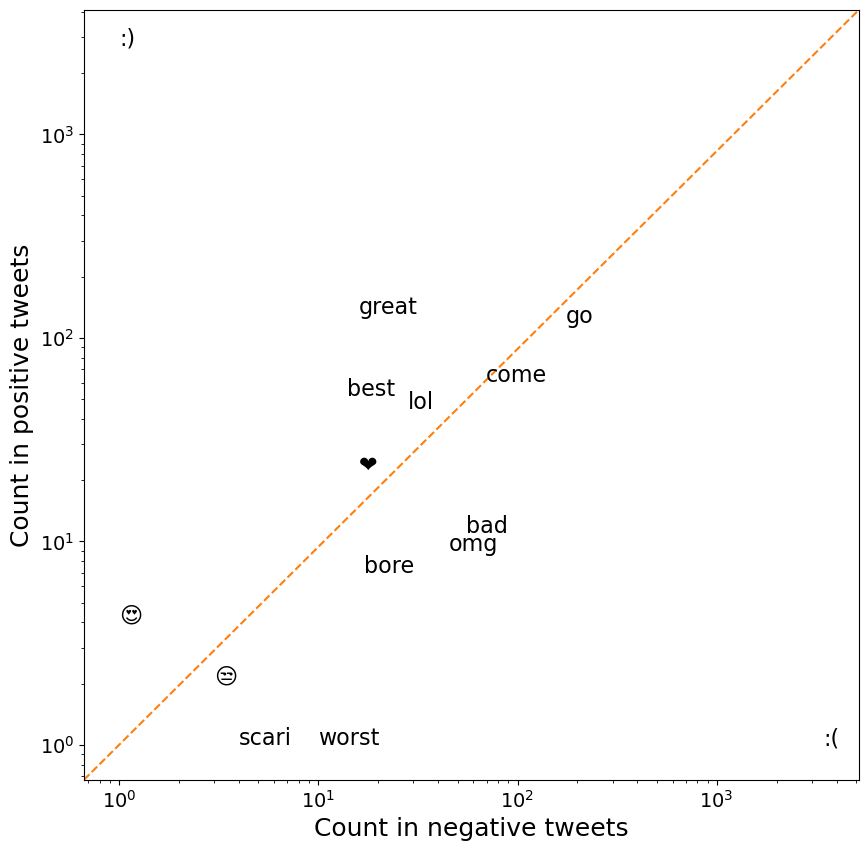

In [22]:
keys = ['❤', '😍', '😒', ':)', ':(','great','bad','scari','bore','best','worst','omg','lol','come','go']\

A = np.array([word_count[key] for key in keys])

plt.figure(figsize=(10,10))
plt.loglog(A[:,0],A[:,1],'.',markersize=0)  
xlim = plt.xlim()
ylim = plt.ylim()
plt.loglog(xlim,ylim,'--')
plt.xlim(xlim)
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel("Count in positive tweets", fontsize=18)
plt.xlabel("Count in negative tweets", fontsize=18)

for i in range(0, len(keys)):
    plt.annotate(keys[i], A[i,:], fontsize=16)

In [23]:
bow_matrix_train = np.zeros((len(X_train_pp),len(unique_words)))
for i, tweet in enumerate(X_train_pp):
    for word in tweet:
        bow_matrix_train[i,unique_words==word] += 1

np.sum(bow_matrix_train!=0)/np.prod(bow_matrix_train.shape)

np.float64(0.0007370435691423345)

In [24]:
# Test data
X_test_pp = preprocess_text(X_test)
bow_matrix_test = np.zeros((len(X_test_pp),len(unique_words)))
for i, tweet in enumerate(X_test_pp):
    for word in tweet:
        if word in unique_words:
            bow_matrix_test[i,unique_words==word] += 1


### Step 5: Train Classifiers
**Naive Bayes** (hand-coded + scikit-learn):
- No optimization needed—just count + Laplace smoothing (α=1)
- **Test accuracy: 99.8%** (5/2,500 errors)

**Logistic Regression**:
- **Test accuracy: 99.9%** (2/2,500 errors)

In [25]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB(alpha=1.0, fit_prior=False).fit(bow_matrix_train,y_train)

In [26]:
print(naive_bayes.feature_log_prob_[1])

[-10.63270144  -9.53408915  -9.93955426 ...  -9.53408915 -10.63270144
 -10.63270144]


In [27]:
naive_bayes.score(bow_matrix_test, y_test)

0.998

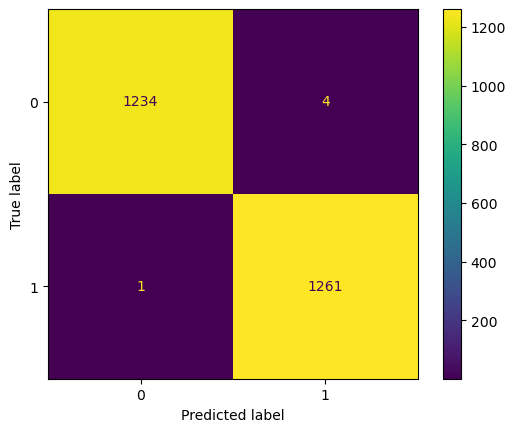

In [28]:
ConfusionMatrixDisplay.from_estimator(naive_bayes, bow_matrix_test, y_test)

In [29]:
from sklearn.linear_model import LogisticRegression
lr_full = LogisticRegression().fit(bow_matrix_train,y_train)

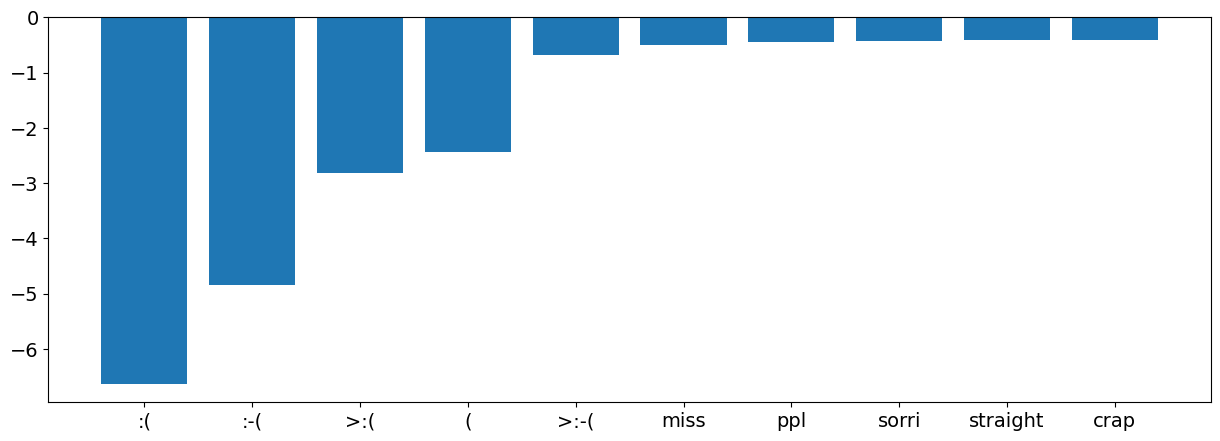

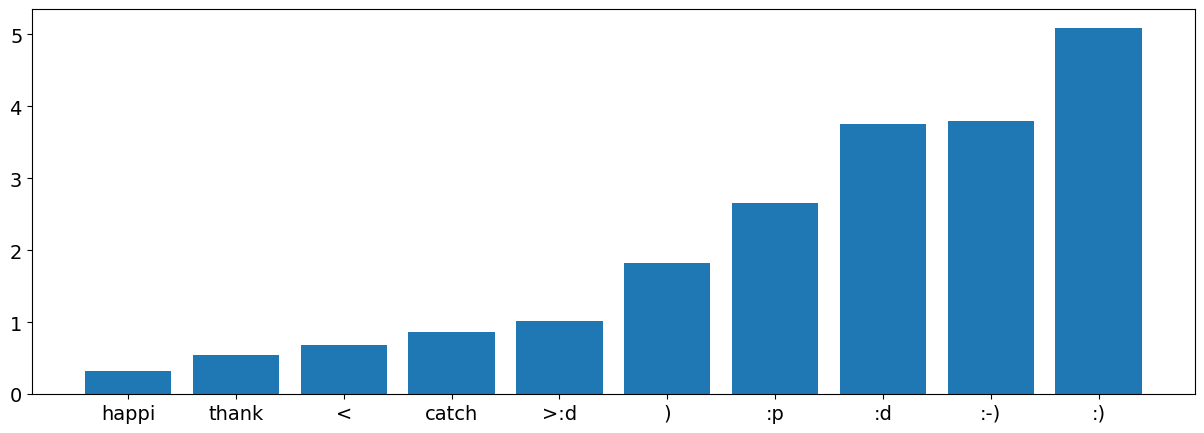

In [30]:
ind = np.argsort(lr_full.coef_[0])

n = 10
plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[:n]], lr_full.coef_[0,ind[:n]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.figure(figsize=(15,5))
plt.bar([unique_words[i] for i in ind[-n:]], lr_full.coef_[0,ind[-n:]])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [31]:
lr_full.score(bow_matrix_test, y_test)

0.9992

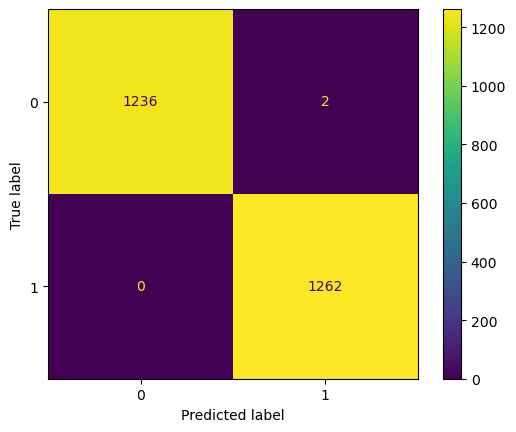

In [32]:
ConfusionMatrixDisplay.from_estimator(lr_full, bow_matrix_test, y_test)


### Step 6: Feature Analysis
**Top coefficients reveal the secret:**
```
Most NEGATIVE: :(, sad, worst, bad, hate
Most POSITIVE: :-), great, best, love, lol
```

**Emoji hack:** Smiling/frowning faces appear in nearly ALL tweets → simple rule dominates!



### Step 7: Extreme Simplification
Using **ONLY 2 features** (🙂, 😞 emoticons):
```
Logistic Regression: 99.9% (1 error)
Naive Bayes: 99.9% (1 error)
```
**Why?** 5,000x dimension reduction (10K → 2 features), sparsity drops (0.08% → 40%).


## Key Takeaways
1. **TweetTokenizer** > word_tokenize for social media
2. **Emoticons = gold** for sentiment (strong, frequent signals)
3. **Bag-of-words works amazingly** on simple tasks
4. **Naive Bayes competes** with Logistic Regression (no optimization!)
5. **Sparsity is normal** in NLP (SciPy sparse matrices help)